## Feature Engineering and WoE binning

This notebook outlines a comprehensive data preprocessing and feature engineering pipeline tailored for customer transaction data. This pipeline includes feature creation, encoding, handling missing values, normalization, scoring using RFMS (Recency, Frequency, Monetary, Size), labeling, and Weight of Evidence (WOE) binning.


- Compute the RFMS score for each customer based on:

    - Recency: Days since the last transaction.
    - Frequency: Total number of transactions.
    - MonetaryTotal: Total amount spent.
    - MonetaryAvg: Average transaction amount.


- Label Encoding:

    0 for good customers (RFMS_Score > threshold).
    1 for bad customers (RFMS_Score ≤ threshold)

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [9]:
# importing modules from scripts 
from scripts.feature_engineering import *
from scripts.logger import setup_logger

In [10]:
#logger
logger = setup_logger('feature_engineering_logger', '../logs/fe.log')

In [11]:
# Load the data
df = pd.read_csv('../data/data.csv')
logger.info("Data loaded successfully.")
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

In [12]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 non-null  float64            
 12  Valu

In [13]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


### summary statistics

In [14]:
# summary statistics
df.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


### Aggregate Features
In this section, features are extracted by aggregating transaction data for each customer. These features capture key characteristics of customers' behavior:

- TotalTransactionAmount: Sum of all transaction amounts for each customer. This helps capture the overall transaction behavior.
- AverageTransactionAmount: The average transaction amount per customer provides insight into typical transaction size.
- TransactionCount: The total number of transactions made by each customer.
- StdDevTransactionAmount: This feature measures the variability in transaction amounts, which can indicate erratic behavior

In [15]:
#  Create Aggregate Features
df = create_aggregate_features(df)
print("\nAfter creating aggregate features:")
print(df[['CustomerId', 'TotalTransactionAmount', 'AverageTransactionAmount', 'TransactionCount', 'StdDevTransactionAmount']].head())
logger.info("creating aggregate features on Amount")


After creating aggregate features:
        CustomerId  TotalTransactionAmount  AverageTransactionAmount  \
0  CustomerId_4406               109921.75                923.712185   
1  CustomerId_4406               109921.75                923.712185   
2  CustomerId_4683                 1000.00                500.000000   
3   CustomerId_988               228727.20               6019.136842   
4   CustomerId_988               228727.20               6019.136842   

   TransactionCount  StdDevTransactionAmount  
0               119              3042.294251  
1               119              3042.294251  
2                 2                 0.000000  
3                38             17169.241610  
4                38             17169.241610  


### Extract Date and Time Features

Time-based features are extracted from TransactionStartTime column to provide additional insights into customer behavior patterns:

    - TransactionHour: The specific hour of the day when the transaction occurred. Certain hours may be linked to high or low activity, which can influence risk assessment.
    - TransactionDay, TransactionMonth, TransactionYear: Extracting the day, month, and year from the TransactionStartTime to capture any temporal trends that could affect credit behavior.

In [16]:
# Extract Time Features
df = extract_time_features(df)
print("\nAfter extracting time features:")
print(df[['CustomerId', 'TransactionStartTime', 'TransactionHour', 'TransactionDay', 'TransactionMonth', 'TransactionYear']].head())
logger.info("extracted features from TransactionStartTime ")


After extracting time features:
        CustomerId      TransactionStartTime  TransactionHour  TransactionDay  \
0  CustomerId_4406 2018-11-15 02:18:49+00:00                2              15   
1  CustomerId_4406 2018-11-15 02:19:08+00:00                2              15   
2  CustomerId_4683 2018-11-15 02:44:21+00:00                2              15   
3   CustomerId_988 2018-11-15 03:32:55+00:00                3              15   
4   CustomerId_988 2018-11-15 03:34:21+00:00                3              15   

   TransactionMonth  TransactionYear  
0                11             2018  
1                11             2018  
2                11             2018  
3                11             2018  
4                11             2018  


In [17]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,PricingStrategy,FraudResult,TotalTransactionAmount,AverageTransactionAmount,TransactionCount,StdDevTransactionAmount,TransactionHour,TransactionDay,TransactionMonth,TransactionYear
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,2,0,109921.75,923.712185,119,3042.294251,2,15,11,2018
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2,0,109921.75,923.712185,119,3042.294251,2,15,11,2018
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,2,0,1000.00,500.000000,2,0.000000,2,15,11,2018
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,2,0,228727.20,6019.136842,38,17169.241610,3,15,11,2018
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2,0,228727.20,6019.136842,38,17169.241610,3,15,11,2018


In [18]:
df.shape

(95662, 24)

### Encode Categorical Variables
Encode categorical features using one-hot encoding. This transformation ensures that the machine learning models can process these categorical variables effectively

In [19]:
# Encode Categorical Features
categorical_columns = ['ProductCategory', 'ChannelId', 'PricingStrategy','CustomerId','ProviderId']
logger.info("categorical features are encoded using onehot encoder")
print("\nEncoding categorical features...")
df_encoded = encode_categorical_features(df, categorical_columns)
df_encoded.head()


Encoding categorical features...


,TransactionId,BatchId,AccountId,SubscriptionId,CurrencyCode,CountryCode,ProductId,Amount,Value,TransactionStartTime,...,CustomerId_CustomerId_993,CustomerId_CustomerId_994,CustomerId_CustomerId_996,CustomerId_CustomerId_998,ProviderId_ProviderId_1,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,UGX,256,ProductId_10,1000.0,1000,2018-11-15 02:18:49+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,UGX,256,ProductId_6,-20.0,20,2018-11-15 02:19:08+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,UGX,256,ProductId_1,500.0,500,2018-11-15 02:44:21+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,UGX,256,ProductId_21,20000.0,21800,2018-11-15 03:32:55+00:00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,UGX,256,ProductId_6,-644.0,644,2018-11-15 03:34:21+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
#check for Missing Values
df = handle_missing_values(df)
print("\nAfter handling missing values:")
print(df.isnull().sum())


After handling missing values:
TransactionId               0
BatchId                     0
AccountId                   0
SubscriptionId              0
CustomerId                  0
CurrencyCode                0
CountryCode                 0
ProviderId                  0
ProductId                   0
ProductCategory             0
ChannelId                   0
Amount                      0
Value                       0
TransactionStartTime        0
PricingStrategy             0
FraudResult                 0
TotalTransactionAmount      0
AverageTransactionAmount    0
TransactionCount            0
StdDevTransactionAmount     0
TransactionHour             0
TransactionDay              0
TransactionMonth            0
TransactionYear             0
dtype: int64


### Normalize Numerical Features
Scales features to a [0,1] range, making them uniform.

In [21]:
# Normalize/Standardize Numerical Features

df = normalize_features(df)
print("\nAfter normalizing features:")
logger.info("scaled numeric features")
print(df.describe())


After normalizing features:
       CountryCode        Amount         Value  PricingStrategy   FraudResult  \
count      95662.0  9.566200e+04  9.566200e+04     9.566200e+04  9.566200e+04   
mean           0.0 -2.376844e-18 -5.347900e-18     1.342917e-16 -8.616060e-18   
std            0.0  1.000005e+00  1.000005e+00     1.000005e+00  1.000005e+00   
min            0.0 -8.164376e+00 -8.039691e-02    -3.078062e+00 -4.496219e-02   
25%            0.0 -5.488653e-02 -7.817959e-02    -3.492524e-01 -4.496219e-02   
50%            0.0 -4.637114e-02 -7.229109e-02    -3.492524e-01 -4.496219e-02   
75%            0.0 -3.177332e-02 -3.980285e-02    -3.492524e-01 -4.496219e-02   
max            0.0  8.007129e+01  8.016556e+01     2.379557e+00  2.224091e+01   

       TotalTransactionAmount  AverageTransactionAmount  TransactionCount  \
count            9.566200e+04              9.566200e+04      9.566200e+04   
mean             7.368217e-17             -2.376844e-18      1.901475e-17   
std       

In [22]:

df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,PricingStrategy,FraudResult,TotalTransactionAmount,AverageTransactionAmount,TransactionCount,StdDevTransactionAmount,TransactionHour,TransactionDay,TransactionMonth,TransactionYear
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,0.0,ProviderId_6,ProductId_10,airtime,...,-0.349252,-0.044962,0.170118,-0.067623,-0.311831,-0.167524,-2.155530,-0.100739,0.848684,-0.994246
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,0.0,ProviderId_4,ProductId_6,financial_services,...,-0.349252,-0.044962,0.170118,-0.067623,-0.311831,-0.167524,-2.155530,-0.100739,0.848684,-0.994246
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,0.0,ProviderId_6,ProductId_1,airtime,...,-0.349252,-0.044962,0.165122,-0.072568,-0.444993,-0.201719,-2.155530,-0.100739,0.848684,-0.994246
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,0.0,ProviderId_1,ProductId_21,utility_bill,...,-0.349252,-0.044962,0.175567,-0.008155,-0.404020,-0.008737,-1.949214,-0.100739,0.848684,-0.994246
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,0.0,ProviderId_4,ProductId_6,financial_services,...,-0.349252,-0.044962,0.175567,-0.008155,-0.404020,-0.008737,-1.949214,-0.100739,0.848684,-0.994246


### RFMS Scoring
RFMS is a common method for customer segmentation in credit risk models. Scores were computed to classify customers as high-risk (bad) or low-risk (good) based on:

Recency (R): Time since the last transaction
Frequency (F): Transaction count
Monetary (M): Total transaction value

In [23]:
# Calculate RFMS scores
rfms_scores = rfms_score(df)
print("\nRFMS scores:")
rfms_scores.head()
logger.info("RFM Scores are calculated")


RFMS scores:


In [24]:
rfms_scores.tail()

,Recency,Frequency,MonetaryTotal,MonetaryAvg,Recency_Normalized,Frequency_Normalized,MonetaryTotal_Normalized,MonetaryAvg_Normalized,RFMS_Score
CustomerId,,,,,,,,,
CustomerId_992,4,6,-0.164688,-0.027448,0.044444,0.001222,0.615463,0.047451,0.404923
CustomerId_993,25,5,-0.110207,-0.022041,0.277778,0.000978,0.615495,0.047525,0.346555
CustomerId_994,0,101,-1.091831,-0.010810,0.000000,0.024450,0.614932,0.047678,0.421765
CustomerId_996,67,17,0.201098,0.011829,0.744444,0.003912,0.615673,0.047988,0.230782
CustomerId_998,0,22,-0.387593,-0.017618,0.000000,0.005134,0.615336,0.047585,0.417014


### Distribution of RFMS scores

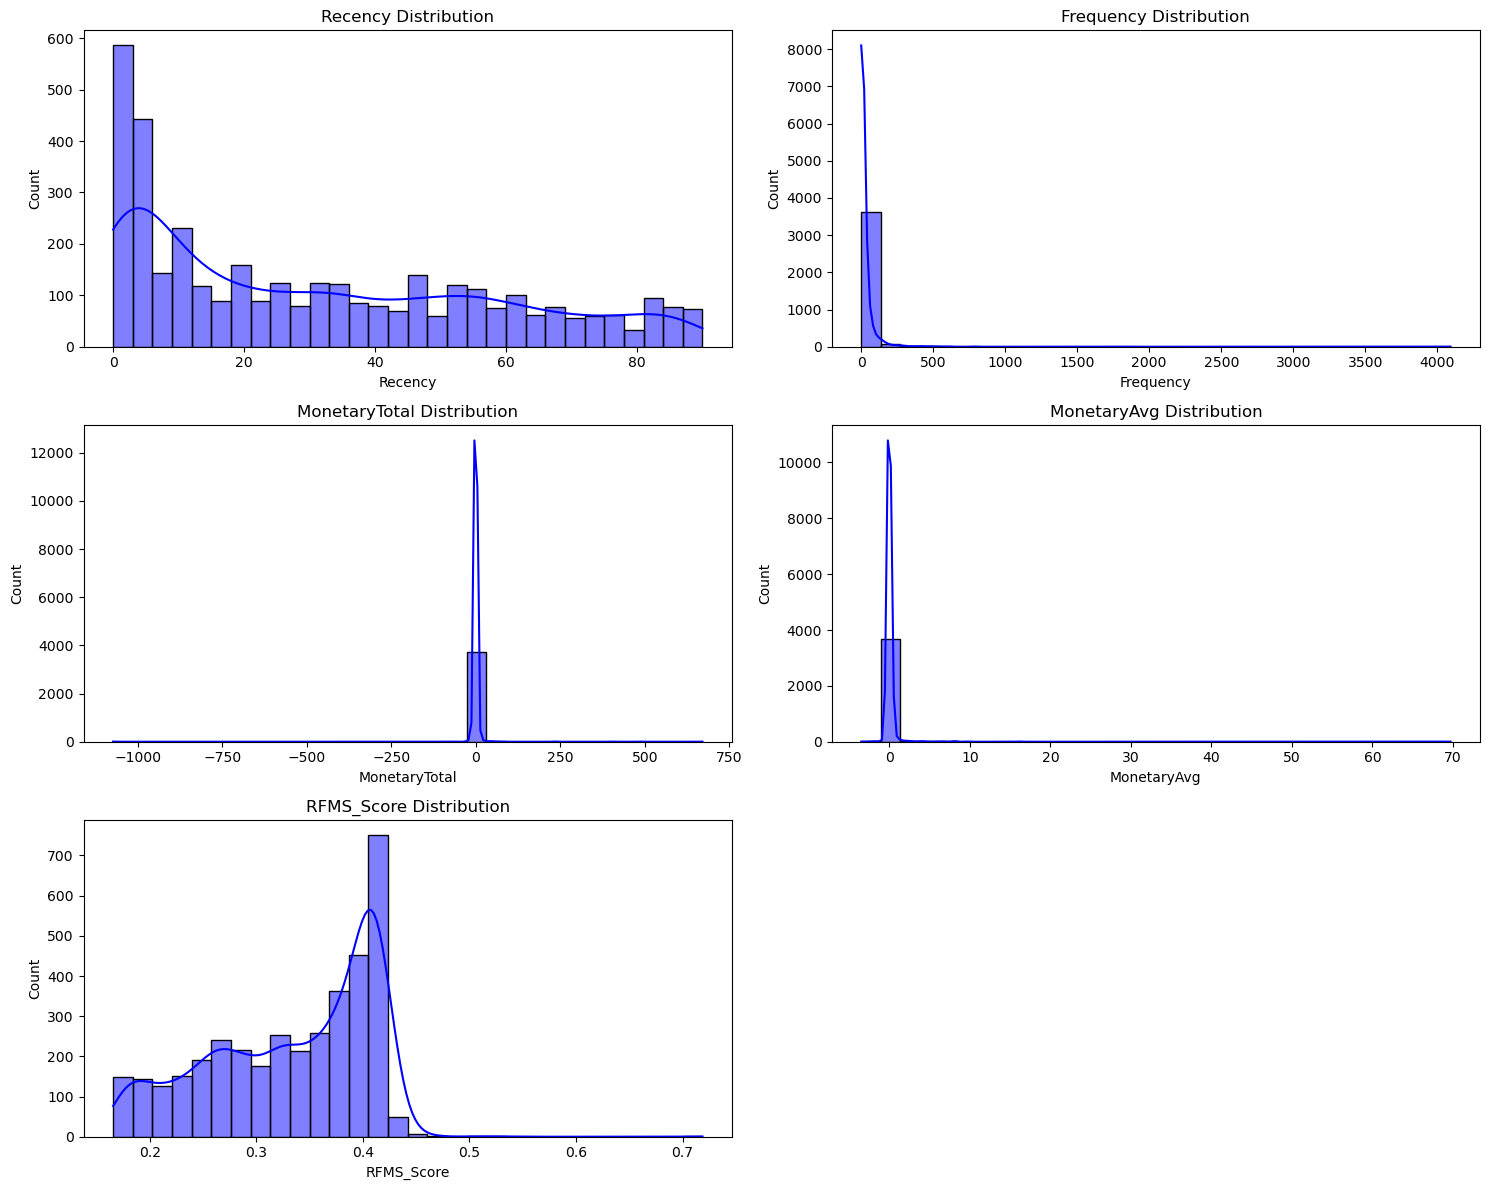

In [25]:
plot_rfms_distributions(rfms_scores)


- Recency Distribution: This plot shows how recent customer interactions are, with a heavy skew towards low recency values (many customers interacting recently).
- The Frequency and MonetaryAvg/MonetaryTotal distributions are heavily right-skewed, suggesting that a majority of customers have low transaction counts and low spending
- RFMS_Score Distribution: The RFMS_Score distribution appears more balanced, with a peak around 0.4, indicating that most customers fall within a moderate range of the scoring system


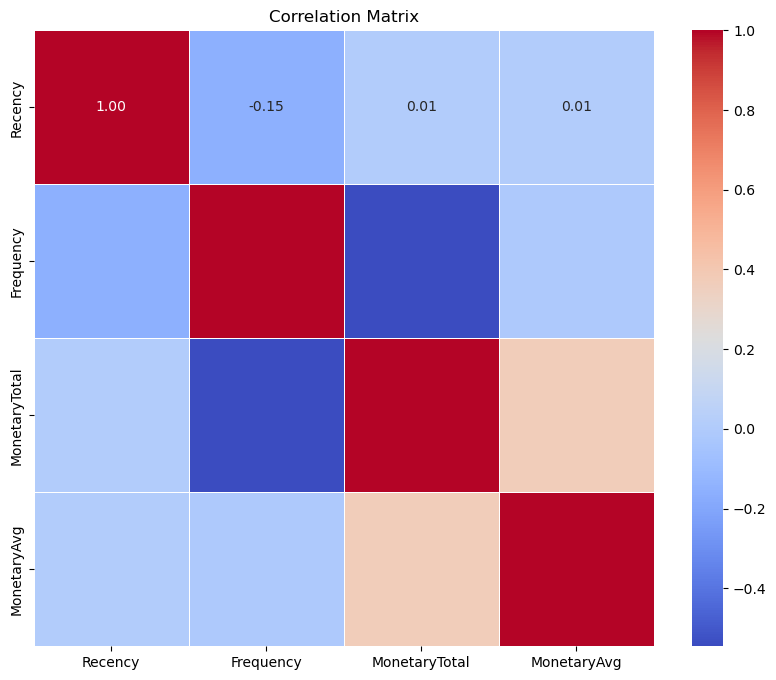

In [26]:
selected_columns = ['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg']
correlation_matrix = rfms_scores[selected_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- Recency and Frequency have a negative correlation of -0.15, meaning that as recency increases, frequency tends to decrease slightly.
- Frequency and MonetaryTotal are moderately negatively correlated (-0.55), indicating that customers who make frequent transactions tend to have a lower total monetary value in those transactions.
- MonetaryTotal and MonetaryAvg have a moderate positive correlation of 0.37, meaning that a higher total monetary value is associated with a higher average transaction value.

In [27]:
print(rfms_scores.columns)

Index(['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg',
       'Recency_Normalized', 'Frequency_Normalized',
       'MonetaryTotal_Normalized', 'MonetaryAvg_Normalized', 'RFMS_Score'],
      dtype='object')


### Assign good/bad labels
Assign good/bad labels based on RFMS score per customer

In [28]:
# Assign good/bad labels
df = assign_good_bad_label(df, rfms_scores)
logger.info(" labels is assigned based on RFMS_Score")
print("\nAfter assigning good/bad labels:")
print(df[['CustomerId', 'RFMS_Score', 'label']].drop_duplicates().head(10))


After assigning good/bad labels:
         CustomerId  RFMS_Score label
0   CustomerId_4406    0.422097  good
2   CustomerId_4683    0.190720   bad
3    CustomerId_988    0.404168  good
5   CustomerId_1432    0.165710   bad
6   CustomerId_2858    0.403454  good
8    CustomerId_598    0.171433   bad
9   CustomerId_1053    0.168820   bad
10  CustomerId_3052    0.246831   bad
16  CustomerId_3105    0.426416  good
19  CustomerId_3507    0.305098   bad


In [29]:
df = df.merge(rfms_scores[['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg']], left_on='CustomerId', right_index=True, how='left')

In [30]:
# Display RFMS values along with RFM_Score and risk label
df[['CustomerId',	'Recency',	'Frequency',	'MonetaryTotal','MonetaryAvg',	'RFMS_Score','label']].head(10)

,CustomerId,Recency,Frequency,MonetaryTotal,MonetaryAvg,RFMS_Score,label
0,CustomerId_4406,0,119,-5.591789,-0.046990,0.422097,good
1,CustomerId_4406,0,119,-5.591789,-0.046990,0.422097,good
2,CustomerId_4683,81,2,-0.100852,-0.050426,0.190720,bad
3,CustomerId_988,5,38,-0.215326,-0.005666,0.404168,good
4,CustomerId_988,5,38,-0.215326,-0.005666,0.404168,good
5,CustomerId_1432,90,1,-0.038261,-0.038261,0.165710,bad
6,CustomerId_2858,5,29,-0.822486,-0.028362,0.403454,good
7,CustomerId_2858,5,29,-0.822486,-0.028362,0.403454,good
8,CustomerId_598,88,4,-0.152558,-0.038140,0.171433,bad
9,CustomerId_1053,89,7,-0.269548,-0.038507,0.168820,bad


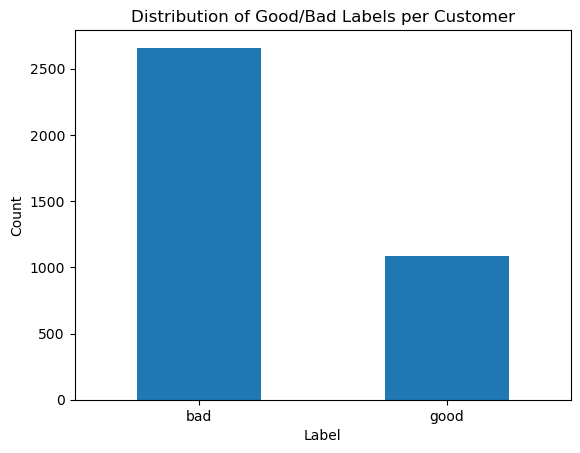

In [31]:
# Get the counts of each label
label_counts = df[['CustomerId', 'label']].drop_duplicates()['label'].value_counts()

# Plot
label_counts.plot(kind='bar')
plt.title('Distribution of Good/Bad Labels per Customer')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keeps the label names horizontal
plt.show()

- The bar chart illustrates the distribution of labels in the dataset with threshold of 0.4, highlighting between the "good" and "bad" classifications. 

    -   ['RFMS_Score'] > threshold, 'good'
    -   ['RFMS_Score'] <> threshold, 'bad'

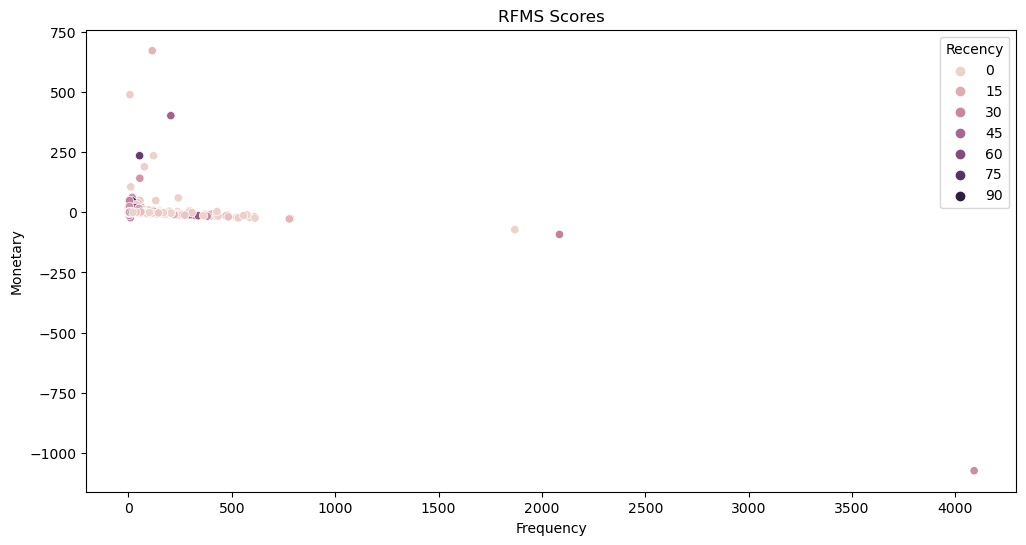

In [32]:
# Visualize RFMS scores
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Frequency', y='MonetaryTotal', hue='Recency', data=rfms_scores)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFMS Scores')
plt.show()

In [33]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,RFMS_Score,label,Recency,Frequency,MonetaryTotal,MonetaryAvg
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,0.0,ProviderId_6,ProductId_10,airtime,...,-2.155530,-0.100739,0.848684,-0.994246,0.422097,good,0,119,-5.591789,-0.046990
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,0.0,ProviderId_4,ProductId_6,financial_services,...,-2.155530,-0.100739,0.848684,-0.994246,0.422097,good,0,119,-5.591789,-0.046990
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,0.0,ProviderId_6,ProductId_1,airtime,...,-2.155530,-0.100739,0.848684,-0.994246,0.190720,bad,81,2,-0.100852,-0.050426
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,0.0,ProviderId_1,ProductId_21,utility_bill,...,-1.949214,-0.100739,0.848684,-0.994246,0.404168,good,5,38,-0.215326,-0.005666
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,0.0,ProviderId_4,ProductId_6,financial_services,...,-1.949214,-0.100739,0.848684,-0.994246,0.404168,good,5,38,-0.215326,-0.005666


In [34]:
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], format='%Y-%m-%d %H:%M:%S')

### Perform WoE binning
- Weight of Evidence (WoE) is a statistical technique used to encode categorical and continuous variables in a way that highlights their predictive power concerning a binary target variable. It transforms the original features into WoE values, which represent the strength and direction of the relationship between each feature and the target.

- The formula to calculate WoE is as follow:
$$
WoE = \frac{(\% \text{ of good customers)}}{(\% \text{ of bad customers)}}
$$


- IV is a measure of a feature’s predictive power for a binary target variable. Higher IV values indicate a stronger relationship between the feature and the target.

- The formula to calculate WoE is as follow:
$$
IV = \sum \left( \% \text{ of good customers} - \% \text{ of bad customers} \right) \times WOE
$$


In [35]:
# Perform Weight of Evidence (WoE) binning on specified features.
features_for_woe = ['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg']
bins = sc.woebin(df, y='label', x=features_for_woe)

df_woe, iv_values = woe_binning(df, target_col='label', features=features_for_woe)


# Select one row per customer for WoE binning
df_unique_customers = df.groupby('CustomerId').first().reset_index()

features_for_woe = ['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg']
bins = sc.woebin(df_unique_customers, y='label', x=features_for_woe)
df_woe, iv_values = woe_binning(df_unique_customers, target_col='label', features=features_for_woe)


[INFO] creating woe binning ...


c:\Users\Tsega KisPay\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


[INFO] creating woe binning ...


c:\Users\Tsega KisPay\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


[INFO] converting into woe values ...
IV for Recency: 5.023946911235862
IV for Frequency: 1.3461000322573455
IV for MonetaryTotal: 1.5629949297425458
IV for MonetaryAvg: 0.18760165043750648
[INFO] creating woe binning ...


c:\Users\Tsega KisPay\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


[INFO] creating woe binning ...


c:\Users\Tsega KisPay\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


[INFO] converting into woe values ...
IV for Recency: 9.060240552983895
IV for Frequency: 1.141042091281409
IV for MonetaryTotal: 0.7030988180020488
IV for MonetaryAvg: 0.2446486130555386


In [36]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,RFMS_Score,label,Recency,Frequency,MonetaryTotal,MonetaryAvg
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,0.0,ProviderId_6,ProductId_10,airtime,...,-2.155530,-0.100739,0.848684,-0.994246,0.422097,good,0,119,-5.591789,-0.046990
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,0.0,ProviderId_4,ProductId_6,financial_services,...,-2.155530,-0.100739,0.848684,-0.994246,0.422097,good,0,119,-5.591789,-0.046990
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,0.0,ProviderId_6,ProductId_1,airtime,...,-2.155530,-0.100739,0.848684,-0.994246,0.190720,bad,81,2,-0.100852,-0.050426
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,0.0,ProviderId_1,ProductId_21,utility_bill,...,-1.949214,-0.100739,0.848684,-0.994246,0.404168,good,5,38,-0.215326,-0.005666
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,0.0,ProviderId_4,ProductId_6,financial_services,...,-1.949214,-0.100739,0.848684,-0.994246,0.404168,good,5,38,-0.215326,-0.005666


### Plot WoE binning results for a specific feature.

<Figure size 1000x600 with 0 Axes>

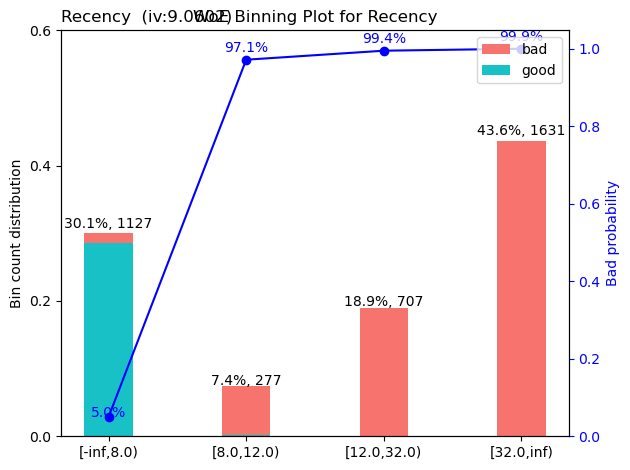

<Figure size 1000x600 with 0 Axes>

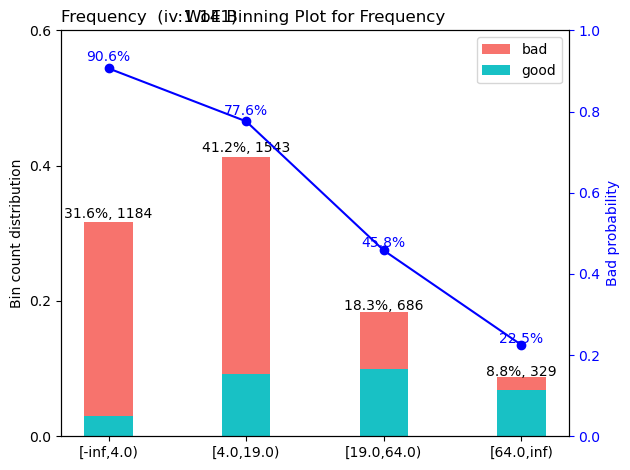

<Figure size 1000x600 with 0 Axes>

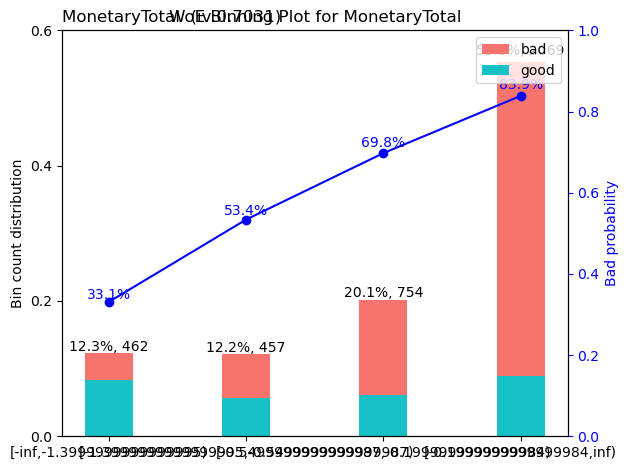

<Figure size 1000x600 with 0 Axes>

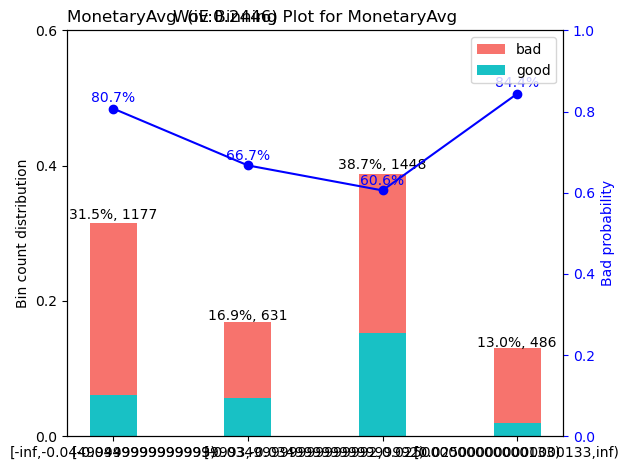

In [37]:
# Plot WoE binning results
for feature in features_for_woe:
    plot_woe_binning(bins, feature)

In [38]:
# # Save the engineered and WoE-transformed datasets
df.to_csv('../data/engineered_data.csv', index=False)
df_woe.to_csv('../data/woe_transformed_data.csv', index=False)